# **Import Dependencies**

In [ ]:
!pip install resampy
!pip install protobuf
!pip install --upgrade resampy
!pip install --upgrade protobuf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.4/294.4 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.0 which is incompatible.


In [ ]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **Data Read and Preprocessing**

In [ ]:
# Audio file upload
audio_dataset_path = '/content/drive/MyDrive/Audio_data'
csv_data = pd.read_csv('/content/drive/MyDrive/Audio_data/UrbanSound8K.csv')
csv_data

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [ ]:
csv_data.shape

(8732, 8)

In [ ]:
csv_data.isnull().sum()

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64

In [ ]:
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


# **Exploratory Data Analysis (EDA)**

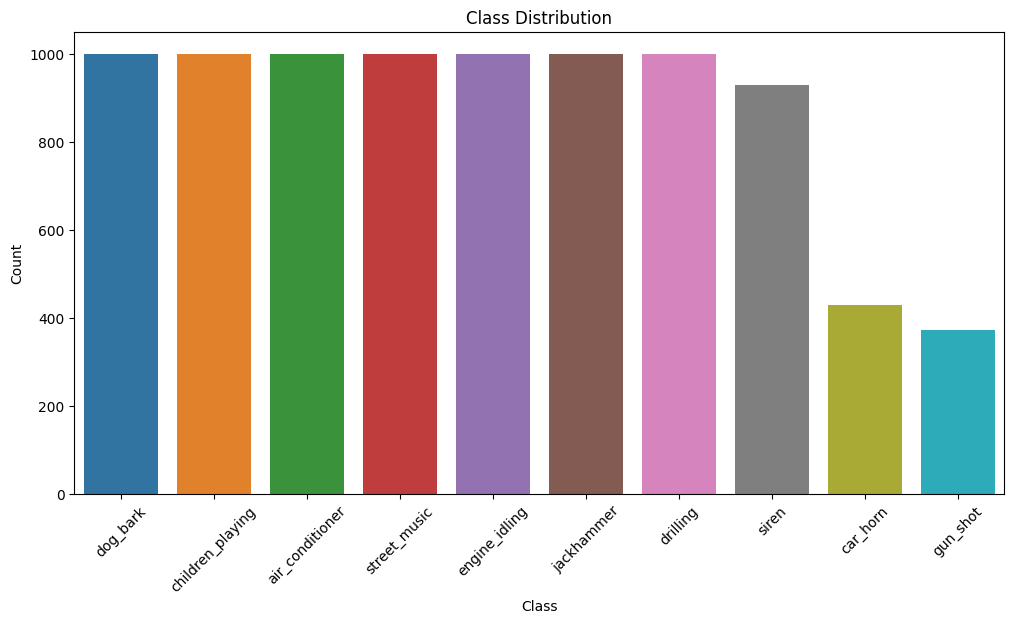

In [ ]:
# Distribution of classes
class_distribution = csv_data['class'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

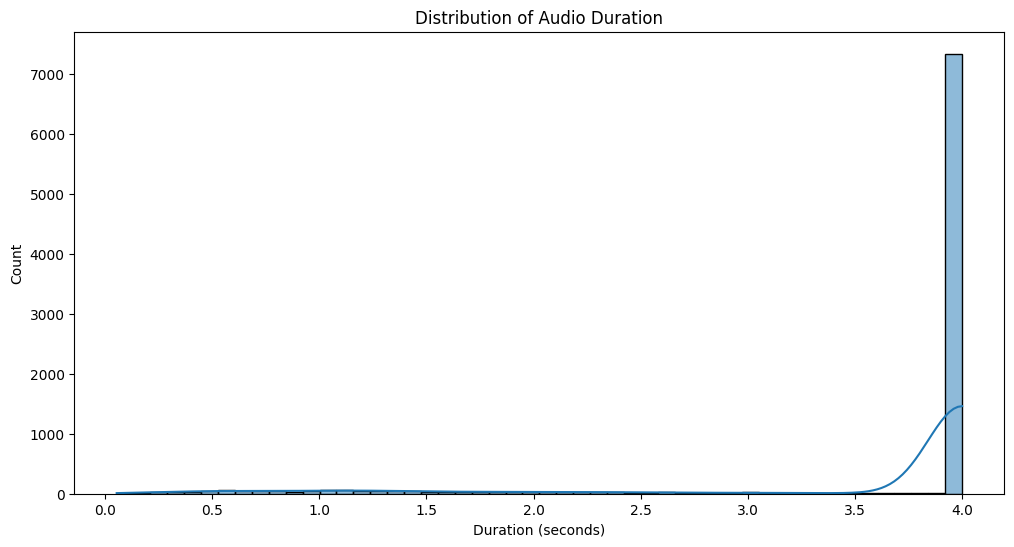

In [ ]:
# Duration of audio files
csv_data['duration'] = csv_data['end'] - csv_data['start']
plt.figure(figsize=(12, 6))
sns.histplot(csv_data['duration'], bins=50, kde=True)
plt.title("Distribution of Audio Duration")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()

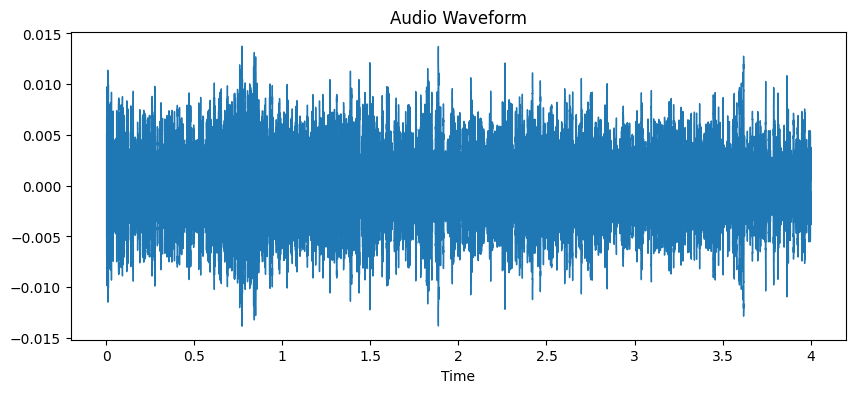

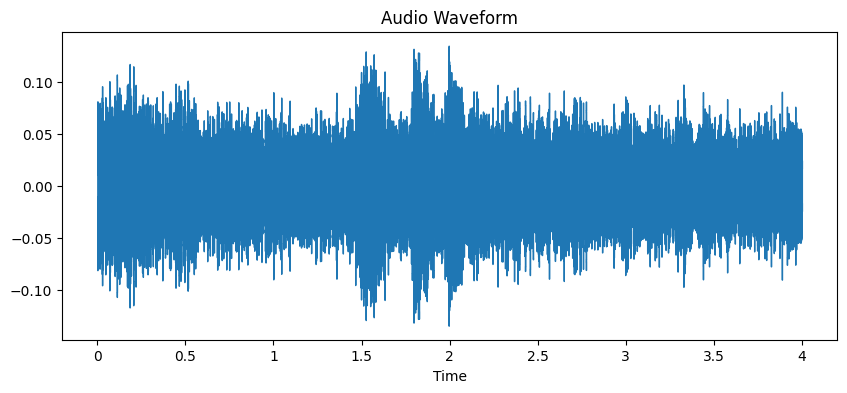

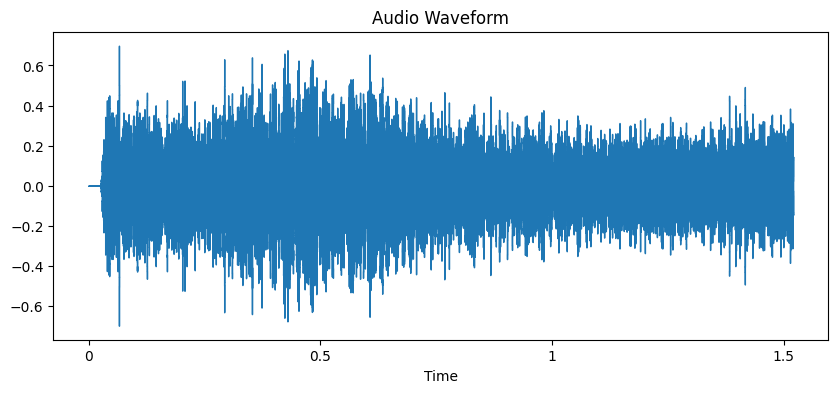

In [ ]:
# Define a function to plot audio waveforms
def plot_waveform(file_path):
    audio, sr = librosa.load(file_path)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title("Audio Waveform")
    plt.show()


# Choose a few audio files to visualize (you can change the file paths)
sample_audio_paths = ['/content/drive/MyDrive/Audio_data/fold5/100263-2-0-3.wav',
                      '/content/drive/MyDrive/Audio_data/fold2/102871-8-0-10.wav',
                      '/content/drive/MyDrive/Audio_data/fold3/103199-4-1-0.wav']

for audio_path in sample_audio_paths:
    plot_waveform(audio_path)

<ipython-input-11-6662a551ea03>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(csv_data.classID)


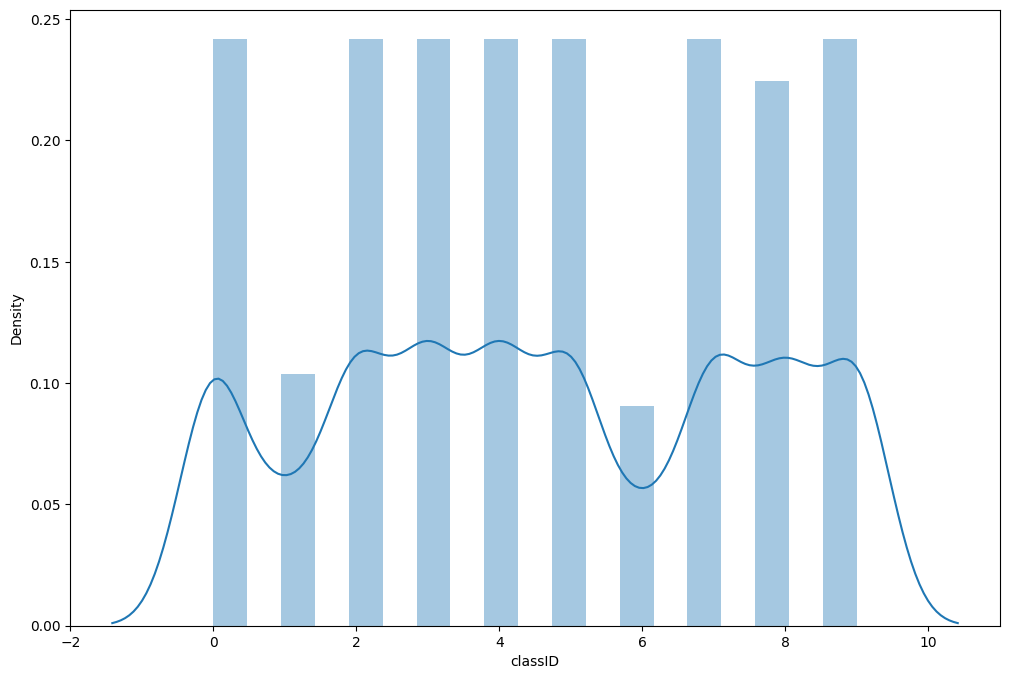

In [ ]:
# Distribution Of Class of Dataset

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
sns.distplot(csv_data.classID)

plt.show()

In [ ]:
# cheacking dataset are balance or not
csv_data['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [ ]:
#Extract MFCC's for every audio file
def features_extractor(file_name):
  audio, sample_rate = librosa.load(file_name, res_type = 'kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features=np.mean(mfccs_features.T,axis=0)

  return mfccs_scaled_features

In [ ]:
# # Features extraction from all audio files (MFCC)
# extracted_features=[]
# for index_num,row in tqdm(csv_data.iterrows()):
#     file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
#     final_class_labels=row["class"]
#     data=features_extractor(file_name)
#     extracted_features.append([data,final_class_labels])

In [ ]:
import pickle
# pickle.dump(extracted_features,open('/content/extracted.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('/content/extracted.pkl','rb'))

In [ ]:

# Converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(loaded_model,columns=['feature','class'])
extracted_features_df.head()

,feature,class


In [ ]:
# Data Frame Saving
extracted_features_df.to_csv("UrbanSound8K_DF.csv")

In [ ]:
# Data Splitting
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
print(X.shape)

(0,)


In [ ]:
y

array([], dtype=float64)

In [ ]:
# Import Libraries for Label Encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

ValueError: ignored

In [ ]:
y

In [ ]:
# Splliting Training Testing Sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

# **Data Standaridization**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

In [ ]:
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
print(X_train_std)
print(X_test_std)

In [ ]:
X_train

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
y_train.shape

In [ ]:
y_test.shape

# **Model Creation and HyperParameterTunning**

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import metrics

In [ ]:
# def build_model(hp):
#   model = Sequential()

#   counter = 0
#   for i in range(hp.Int('num_layers',min_value=1,max_value=10)):
#     if counter == 0:
#       model.add(Dense(units=hp.Int('units'+str(i),min_value=8, max_value=128, step=8),activation=hp.Choice('activation'+str(i),values=['relu','tanh','sigmoid']),input_dim=40))
#       model.add(Dropout(hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))

#     else:
#       model.add(Dense(units=hp.Int('units'+str(i),min_value=8, max_value=128, step=8),activation=hp.Choice('activation'+str(i),values=['relu','tanh','sigmoid'])))
#       model.add(Dropout(hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
#     counter +=1


#     model.add(Dense(1,activation='sigmoid'))

#     model.compile(  optimizer = hp.Choice('optimizer',values=['adam','sgd','rmsprop','adadelta','nadam']),metrics=['accuracy'])


#     return model

In [ ]:
# !pip install -U keras-tuner
# import kerastuner as kt

In [ ]:
# tuner = kt.RandomSearch(build_model,
#                         objective='val_accuracy',
#                         max_trials = 5,
#                         directory='mydir',
#                         project_name='final')

In [ ]:
# tuner.search(X_train, y_train, epochs=5, validation_data=(X_test,y_test))
# tuner.get_best_hyperparameters()[0].values

In [ ]:
# model.fit(X_train,y_train, epochs=100, initial_epoch=5,validation_data=(X_test,y_test))

In [ ]:
# No of classes
num_labels=y.shape[1]
print(num_labels)

In [ ]:
model=Sequential()
#first layer
model.add(Dense(1600,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#second layer
model.add(Dense(800))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#third layer
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
# Model training
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

In [ ]:
num_epochs = 100
num_batch_size = 128

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.h5', verbose=1, save_best_only=True)
start = datetime.now()

y_pred=model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

# **Compare With Diffrent Algorithm**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

In [ ]:
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [ ]:
clfs = {
    'KN' : knc,
    'DT': dtc,
    'RF': rfc,
    'ETC': etc,
    'xgb':xgb
}

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [ ]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred, average='micro')

    return accuracy,precision

In [ ]:
train_classifier(xgb,X_train,y_train,X_test,y_test)

In [ ]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():

    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)

    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

In [ ]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Accuracy',ascending=False)

In [ ]:
performance_df

# **Test On New Audio Data**

In [ ]:
filename="/content/drive/MyDrive/Audio_data/fold7/102853-8-0-0.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [ ]:
mfccs_scaled_features.shape

In [ ]:

mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features.shape)
predicted_label = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
prediction_class = labelencoder.inverse_transform(predicted_label)
print('Predicted Label:',predicted_label)
print('Predicted Class:',prediction_class[0])
ipd.Audio(filename)
